### 기존 코드에서 수정사항
- experiment_name에서 시간 삭제
- 기존에 데이터셋 불러오는 lib.Dataset 함수를 사용하지 않음
- as_tensor 함수 사용할 때 dtype=torch.float32 지정 --> trainer.py의 118, 119 line도 수정함
- 타겟변수의 초기화값을 normal 분포 대신 np.min(train_y) np.max(train_y) 사이의 값을 갖도록 하기 위해 수정 --> odst.py의 ODST 클래스에 ir(어떤 분포 사용할건지), ir_min(uniform일 때 최소값), ir_max(uniform일 때 최대값) 인자 추가하고, ir=='uniform'일 경우 U(np.min(train_y) np.max(train_y)) 를 따르는 값으로 초기화되도록 변경

In [15]:
#!pip install tensorboardX
#!pip install qhoptim

In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=0
import os, sys
import time
sys.path.insert(0, '..')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import lib
import torch, torch.nn as nn
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

env: CUDA_VISIBLE_DEVICES=0


#### 데이터 load & 전처리

In [2]:
data = pd.read_csv('housing.csv')

# 범주형 변수를 수치형으로 변환
le = LabelEncoder()
le = le.fit(data['ocean_proximity'])  
data['ocean_proximity'] = le.transform(data['ocean_proximity'])

# median house value가 500000보다 큰 데이터는 모두 500001로 기록됨 -> 분석에서 제외
data = data[data['median_house_value'] != 500001]

# na 처리
data = data.dropna(axis=0)   # na 값이 포함된 행은 제거

X = data.drop('median_house_value', axis=1)
y = data['median_house_value']
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=777)
train_x.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4748,-118.35,34.05,52.0,1971.0,414.0,1065.0,409.0,3.6435,0
15001,-117.02,32.74,12.0,3301.0,963.0,2000.0,879.0,1.8594,4
5634,-118.28,33.74,40.0,1751.0,512.0,1939.0,503.0,1.5394,4
9084,-118.19,34.67,8.0,11275.0,1822.0,5731.0,1692.0,5.0285,1
10781,-117.90,33.64,36.0,2017.0,357.0,850.0,348.0,5.0532,0


In [3]:
def getpr2(testy, predy):
    result = 1 - sum((testy - predy)**2) / sum((testy - np.mean(testy))**2)
    return result

In [4]:
train_x, train_y = train_x.values, train_y.values
test_x, test_y = test_x.values, test_y.values

In [5]:
# validation set 생성
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=777)

#### Modeling

In [12]:
from qhoptim.pyt import QHAdam
from tqdm import tqdm
from IPython.display import clear_output

In [24]:
mu, std = train_y.mean(), train_y.std()
normalize = lambda x: ((x - mu) / std).astype(np.float32)
train_y, valid_y, test_y = map(normalize, [train_y, valid_y, test_y])

print("mean = %.5f, std = %.5f" % (mu, std))

mean = 192398.50738, std = 97339.89818


In [42]:
experiment_name = 'California 0724-4'  # experiment 이름 지정
print("experiment:", experiment_name)

experiment: California 0724-4


In [43]:
in_features = train_x.shape[1]

model = nn.Sequential(
    lib.DenseBlock(in_features, 128, num_layers=6, tree_dim=3, depth=6, flatten_output=False,
                   choice_function=lib.entmax15, bin_function=lib.entmoid15),
    lib.Lambda(lambda x: x[..., 0].mean(dim=-1)),  # average first channels of every tree
    
).to(device)

# with torch.no_grad():
#     res = model(torch.as_tensor(train_x[:5000], device=device, dtype=torch.float32))
    # trigger data-aware init
    
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [44]:
optimizer_params = { 'nus':(0.7, 1.0), 'betas':(0.95, 0.998) }

In [45]:
trainer = lib.Trainer(
    model=model, loss_function=F.mse_loss,
    experiment_name=experiment_name,
    warm_start=False,
    Optimizer=QHAdam,
    optimizer_params=optimizer_params,
    verbose=True,
    n_last_checkpoints=5
)

In [46]:
loss_history, mse_history = [], []
best_mse = float('inf')
best_step_mse = 0
early_stopping_rounds = 100
report_frequency = 50

In [47]:
for batch in tqdm(lib.iterate_minibatches(train_x, train_y, batch_size=1024, 
                                                shuffle=True, epochs=100)):
    
    metrics = trainer.train_on_batch(*batch, device=device)
    
    loss_history.append(metrics['loss'])

    if trainer.step % report_frequency == 0:
        trainer.save_checkpoint()
        trainer.average_checkpoints(out_tag='avg')
        trainer.load_checkpoint(tag='avg')
        mse = trainer.evaluate_mse(
            valid_x, valid_y, device=device, batch_size=1024)

        if mse < best_mse:
            best_mse = mse
            best_step_mse = trainer.step
            trainer.save_checkpoint(tag='best_mse')
        mse_history.append(mse)
        
        trainer.load_checkpoint()  # last
        trainer.remove_old_temp_checkpoints()
        
        print("iteration:{} loss:{} mse:{}".format(trainer.step, metrics['loss'], mse))
#         clear_output(True)
#         plt.figure(figsize=[18, 6])
#         plt.subplot(1, 2, 1)
#         plt.plot(loss_history)
#         plt.title('Loss')
#         plt.grid()
#         plt.subplot(1, 2, 2)
#         plt.plot(mse_history)
#         plt.title('MSE')
#         plt.grid()
#         plt.show()
#         print("Loss %.5f" % (metrics['loss']))
#         print("Val MSE: %0.5f" % (mse))
    if trainer.step > best_step_mse + early_stopping_rounds:
        print('BREAK. There is no improvment for {} steps'.format(early_stopping_rounds))
        print("Best step: ", best_step_mse)
        print("Best Val MSE: %0.5f" % (best_mse))
        break

49it [04:27,  5.33s/it]

Saved logs/California 0724-4\checkpoint_temp_50.pth
Loaded logs/California 0724-4\checkpoint_avg.pth


50it [04:37,  6.86s/it]

Saved logs/California 0724-4\checkpoint_best_mse.pth
Loaded logs/California 0724-4\checkpoint_temp_50.pth
iteration:50 loss:0.795038104057312 mse:0.8481542468070984


99it [08:53,  5.76s/it]

Saved logs/California 0724-4\checkpoint_temp_100.pth
Loaded logs/California 0724-4\checkpoint_avg.pth


100it [09:05,  7.47s/it]

Saved logs/California 0724-4\checkpoint_best_mse.pth
Loaded logs/California 0724-4\checkpoint_temp_100.pth
iteration:100 loss:0.7286220788955688 mse:0.8014309406280518


149it [13:35,  5.96s/it]

Saved logs/California 0724-4\checkpoint_temp_150.pth
Loaded logs/California 0724-4\checkpoint_avg.pth


150it [13:46,  7.44s/it]

Saved logs/California 0724-4\checkpoint_best_mse.pth
Loaded logs/California 0724-4\checkpoint_temp_150.pth
iteration:150 loss:0.6981112957000732 mse:0.7509468793869019


199it [18:10,  5.94s/it]

Saved logs/California 0724-4\checkpoint_temp_200.pth
Loaded logs/California 0724-4\checkpoint_avg.pth


200it [18:22,  7.77s/it]

Saved logs/California 0724-4\checkpoint_best_mse.pth
Loaded logs/California 0724-4\checkpoint_temp_200.pth
iteration:200 loss:0.6317655444145203 mse:0.7127852439880371


249it [22:54,  5.03s/it]

Saved logs/California 0724-4\checkpoint_temp_250.pth
Loaded logs/California 0724-4\checkpoint_avg.pth


250it [23:07,  7.43s/it]

Saved logs/California 0724-4\checkpoint_best_mse.pth
Loaded logs/California 0724-4\checkpoint_temp_250.pth
iteration:250 loss:0.6059958338737488 mse:0.6794520020484924


299it [27:20,  4.23s/it]

Saved logs/California 0724-4\checkpoint_temp_300.pth
Loaded logs/California 0724-4\checkpoint_avg.pth


300it [27:31,  6.18s/it]

Saved logs/California 0724-4\checkpoint_best_mse.pth
Loaded logs/California 0724-4\checkpoint_temp_300.pth
iteration:300 loss:0.5178478360176086 mse:0.6119393110275269


349it [32:10,  5.99s/it]

Saved logs/California 0724-4\checkpoint_temp_350.pth
Loaded logs/California 0724-4\checkpoint_avg.pth


350it [32:21,  7.58s/it]

Saved logs/California 0724-4\checkpoint_best_mse.pth
Loaded logs/California 0724-4\checkpoint_temp_350.pth
iteration:350 loss:0.47971707582473755 mse:0.5633949041366577


399it [36:35,  5.37s/it]

Saved logs/California 0724-4\checkpoint_temp_400.pth
Loaded logs/California 0724-4\checkpoint_avg.pth


400it [36:45,  6.91s/it]

Saved logs/California 0724-4\checkpoint_best_mse.pth
Loaded logs/California 0724-4\checkpoint_temp_400.pth
iteration:400 loss:0.4718688428401947 mse:0.5271509885787964


449it [40:57,  5.49s/it]

Saved logs/California 0724-4\checkpoint_temp_450.pth
Loaded logs/California 0724-4\checkpoint_avg.pth


450it [41:07,  7.03s/it]

Saved logs/California 0724-4\checkpoint_best_mse.pth
Loaded logs/California 0724-4\checkpoint_temp_450.pth
iteration:450 loss:0.5337320566177368 mse:0.500442385673523


499it [45:37,  5.58s/it]

Saved logs/California 0724-4\checkpoint_temp_500.pth
Loaded logs/California 0724-4\checkpoint_avg.pth


500it [45:48,  7.17s/it]

Saved logs/California 0724-4\checkpoint_best_mse.pth
Loaded logs/California 0724-4\checkpoint_temp_500.pth
iteration:500 loss:0.4440693259239197 mse:0.4789286255836487


549it [50:20,  5.60s/it]

Saved logs/California 0724-4\checkpoint_temp_550.pth
Loaded logs/California 0724-4\checkpoint_avg.pth


550it [50:31,  7.41s/it]

Saved logs/California 0724-4\checkpoint_best_mse.pth
Loaded logs/California 0724-4\checkpoint_temp_550.pth
iteration:550 loss:0.41394832730293274 mse:0.4598309099674225


599it [55:01,  5.02s/it]

Saved logs/California 0724-4\checkpoint_temp_600.pth
Loaded logs/California 0724-4\checkpoint_avg.pth


600it [55:13,  7.05s/it]

Saved logs/California 0724-4\checkpoint_best_mse.pth
Loaded logs/California 0724-4\checkpoint_temp_600.pth
iteration:600 loss:0.36986619234085083 mse:0.44431909918785095


649it [59:46,  5.50s/it]

Saved logs/California 0724-4\checkpoint_temp_650.pth
Loaded logs/California 0724-4\checkpoint_avg.pth


650it [59:53,  6.03s/it]

Saved logs/California 0724-4\checkpoint_best_mse.pth
Loaded logs/California 0724-4\checkpoint_temp_650.pth
iteration:650 loss:0.412624329328537 mse:0.43018290400505066


699it [1:04:14,  5.58s/it]

Saved logs/California 0724-4\checkpoint_temp_700.pth
Loaded logs/California 0724-4\checkpoint_avg.pth


700it [1:04:25,  7.26s/it]

Saved logs/California 0724-4\checkpoint_best_mse.pth
Loaded logs/California 0724-4\checkpoint_temp_700.pth
iteration:700 loss:0.38942718505859375 mse:0.418210506439209


749it [1:08:41,  5.54s/it]

Saved logs/California 0724-4\checkpoint_temp_750.pth
Loaded logs/California 0724-4\checkpoint_avg.pth


750it [1:08:53,  7.25s/it]

Saved logs/California 0724-4\checkpoint_best_mse.pth
Loaded logs/California 0724-4\checkpoint_temp_750.pth
iteration:750 loss:0.36050933599472046 mse:0.40817978978157043


799it [1:13:33,  5.90s/it]

Saved logs/California 0724-4\checkpoint_temp_800.pth
Loaded logs/California 0724-4\checkpoint_avg.pth


800it [1:13:45,  7.66s/it]

Saved logs/California 0724-4\checkpoint_best_mse.pth
Loaded logs/California 0724-4\checkpoint_temp_800.pth
iteration:800 loss:0.35398173332214355 mse:0.3992029130458832


849it [1:18:06,  5.14s/it]

Saved logs/California 0724-4\checkpoint_temp_850.pth
Loaded logs/California 0724-4\checkpoint_avg.pth


850it [1:18:17,  6.77s/it]

Saved logs/California 0724-4\checkpoint_best_mse.pth
Loaded logs/California 0724-4\checkpoint_temp_850.pth
iteration:850 loss:0.364694744348526 mse:0.39249861240386963


899it [1:22:37,  5.44s/it]

Saved logs/California 0724-4\checkpoint_temp_900.pth
Loaded logs/California 0724-4\checkpoint_avg.pth


900it [1:22:49,  7.35s/it]

Saved logs/California 0724-4\checkpoint_best_mse.pth
Loaded logs/California 0724-4\checkpoint_temp_900.pth
iteration:900 loss:0.3504689037799835 mse:0.3828699290752411


949it [1:27:14,  4.41s/it]

Saved logs/California 0724-4\checkpoint_temp_950.pth
Loaded logs/California 0724-4\checkpoint_avg.pth


950it [1:27:24,  6.36s/it]

Saved logs/California 0724-4\checkpoint_best_mse.pth
Loaded logs/California 0724-4\checkpoint_temp_950.pth
iteration:950 loss:0.3522582948207855 mse:0.37620529532432556


999it [1:31:55,  5.71s/it]

Saved logs/California 0724-4\checkpoint_temp_1000.pth
Loaded logs/California 0724-4\checkpoint_avg.pth


1000it [1:32:06,  7.26s/it]

Saved logs/California 0724-4\checkpoint_best_mse.pth
Loaded logs/California 0724-4\checkpoint_temp_1000.pth
iteration:1000 loss:0.37919265031814575 mse:0.372806191444397


1049it [1:36:27,  5.40s/it]

Saved logs/California 0724-4\checkpoint_temp_1050.pth
Loaded logs/California 0724-4\checkpoint_avg.pth


1050it [1:36:38,  7.08s/it]

Saved logs/California 0724-4\checkpoint_best_mse.pth
Loaded logs/California 0724-4\checkpoint_temp_1050.pth
iteration:1050 loss:0.3483409881591797 mse:0.36932381987571716


1099it [1:40:56,  5.63s/it]

Saved logs/California 0724-4\checkpoint_temp_1100.pth
Loaded logs/California 0724-4\checkpoint_avg.pth


1100it [1:41:06,  7.16s/it]

Saved logs/California 0724-4\checkpoint_best_mse.pth
Loaded logs/California 0724-4\checkpoint_temp_1100.pth
iteration:1100 loss:0.35032400488853455 mse:0.36375561356544495


1149it [1:45:32,  5.72s/it]

Saved logs/California 0724-4\checkpoint_temp_1150.pth
Loaded logs/California 0724-4\checkpoint_avg.pth


1150it [1:45:43,  7.32s/it]

Saved logs/California 0724-4\checkpoint_best_mse.pth
Loaded logs/California 0724-4\checkpoint_temp_1150.pth
iteration:1150 loss:0.3465188443660736 mse:0.3574793338775635


1199it [1:50:08,  5.23s/it]

Saved logs/California 0724-4\checkpoint_temp_1200.pth
Loaded logs/California 0724-4\checkpoint_avg.pth


1200it [1:50:20,  7.07s/it]

Saved logs/California 0724-4\checkpoint_best_mse.pth
Loaded logs/California 0724-4\checkpoint_temp_1200.pth
iteration:1200 loss:0.340543270111084 mse:0.3537638485431671


1249it [1:54:46,  5.01s/it]

Saved logs/California 0724-4\checkpoint_temp_1250.pth
Loaded logs/California 0724-4\checkpoint_avg.pth


1250it [1:54:57,  6.84s/it]

Saved logs/California 0724-4\checkpoint_best_mse.pth
Loaded logs/California 0724-4\checkpoint_temp_1250.pth
iteration:1250 loss:0.37070947885513306 mse:0.34377020597457886


1299it [1:59:33,  5.73s/it]

Saved logs/California 0724-4\checkpoint_temp_1300.pth
Loaded logs/California 0724-4\checkpoint_avg.pth


1300it [1:59:40,  5.52s/it]

Saved logs/California 0724-4\checkpoint_best_mse.pth
Loaded logs/California 0724-4\checkpoint_temp_1300.pth
iteration:1300 loss:0.3005267381668091 mse:0.3399961292743683


In [50]:
y_pred = trainer.get_prediction(test_x, test_y, device=device)

In [56]:
print('RMSE: {}'.format(np.sqrt(mean_squared_error(test_y, y_pred))))
print('Pseudo R^2: {}'.format(getpr2(test_y, y_pred)))

RMSE: 0.5976597666740417
Pseudo R^2: 0.6534174120442646


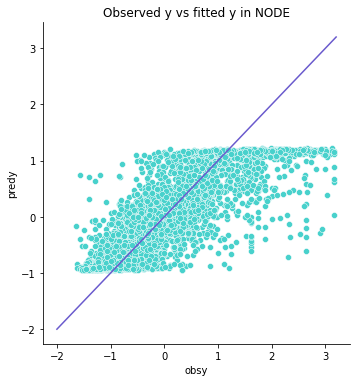

In [57]:
# Observed y vs fitted y
y_df = pd.DataFrame({'obsy':test_y, 'predy':y_pred})
sns.relplot(x='obsy', y='predy', data=y_df, color="mediumturquoise")
plt.plot([-2, 3.2], [-2, 3.2], color="slateblue")
plt.title("Observed y vs fitted y in NODE");

In [73]:
print(np.max(y_pred))
print(np.min(y_pred))

1.2248721
-0.9529595


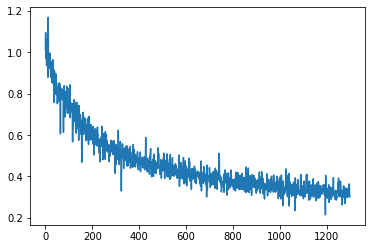

In [61]:
plt.plot(torch.stack(loss_history).detach().numpy());

#### case2: layer 수를 줄이고 epoch을 더 크게

In [65]:
experiment_name = 'California 0724-5'  # experiment 이름 지정
print("experiment:", experiment_name)

experiment: California 0724-5


In [66]:
in_features = train_x.shape[1]

model = nn.Sequential(
    lib.DenseBlock(in_features, 64, num_layers=3, tree_dim=3, depth=6, flatten_output=False,
                   choice_function=lib.entmax15, bin_function=lib.entmoid15),
    lib.Lambda(lambda x: x[..., 0].mean(dim=-1)),  # average first channels of every tree
    
).to(device)

# with torch.no_grad():
#     res = model(torch.as_tensor(train_x[:5000], device=device, dtype=torch.float32))
    # trigger data-aware init
    
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [67]:
optimizer_params = { 'nus':(0.7, 1.0), 'betas':(0.95, 0.998) }
trainer = lib.Trainer(
    model=model, loss_function=F.mse_loss,
    experiment_name=experiment_name,
    warm_start=False,
    Optimizer=QHAdam,
    optimizer_params=optimizer_params,
    verbose=True,
    n_last_checkpoints=5
)

In [68]:
loss_history2, mse_history2 = [], []
best_mse = float('inf')
best_step_mse = 0
early_stopping_rounds = 100
report_frequency = 50

In [69]:
for batch in tqdm(lib.iterate_minibatches(train_x, train_y, batch_size=1024, 
                                                shuffle=True, epochs=300)):
    
    metrics = trainer.train_on_batch(*batch, device=device)
    
    loss_history2.append(metrics['loss'])

    if trainer.step % report_frequency == 0:
        trainer.save_checkpoint()
        trainer.average_checkpoints(out_tag='avg')
        trainer.load_checkpoint(tag='avg')
        mse = trainer.evaluate_mse(
            valid_x, valid_y, device=device, batch_size=1024)

        if mse < best_mse:
            best_mse = mse
            best_step_mse = trainer.step
            trainer.save_checkpoint(tag='best_mse')
        mse_history2.append(mse)
        
        trainer.load_checkpoint()  # last
        trainer.remove_old_temp_checkpoints()
        
        print("iteration:{} loss:{} mse:{}".format(trainer.step, metrics['loss'], mse))
#         clear_output(True)
#         plt.figure(figsize=[18, 6])
#         plt.subplot(1, 2, 1)
#         plt.plot(loss_history)
#         plt.title('Loss')
#         plt.grid()
#         plt.subplot(1, 2, 2)
#         plt.plot(mse_history)
#         plt.title('MSE')
#         plt.grid()
#         plt.show()
#         print("Loss %.5f" % (metrics['loss']))
#         print("Val MSE: %0.5f" % (mse))
    if trainer.step > best_step_mse + early_stopping_rounds:
        print('BREAK. There is no improvment for {} steps'.format(early_stopping_rounds))
        print("Best step: ", best_step_mse)
        print("Best Val MSE: %0.5f" % (best_mse))
        break

49it [00:53,  1.09s/it]

Saved logs/California 0724-5\checkpoint_temp_50.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


50it [00:54,  1.28s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_50.pth
iteration:50 loss:0.9763635993003845 mse:0.9779215455055237


99it [01:48,  1.17s/it]

Saved logs/California 0724-5\checkpoint_temp_100.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


100it [01:50,  1.42s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_100.pth
iteration:100 loss:0.8707801103591919 mse:0.9571326971054077


149it [02:45,  1.24s/it]

Saved logs/California 0724-5\checkpoint_temp_150.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


150it [02:47,  1.45s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_150.pth
iteration:150 loss:0.8843846321105957 mse:0.9329019784927368


199it [03:44,  1.16s/it]

Saved logs/California 0724-5\checkpoint_temp_200.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


200it [03:46,  1.32s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_200.pth
iteration:200 loss:0.8299335837364197 mse:0.907481849193573


249it [04:44,  1.21s/it]

Saved logs/California 0724-5\checkpoint_temp_250.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


250it [04:46,  1.45s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_250.pth
iteration:250 loss:0.7201346158981323 mse:0.8828292489051819


299it [05:46,  1.03it/s]

Saved logs/California 0724-5\checkpoint_temp_300.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


300it [05:48,  1.25s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_300.pth
iteration:300 loss:0.7067774534225464 mse:0.8304242491722107


349it [06:50,  1.30s/it]

Saved logs/California 0724-5\checkpoint_temp_350.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


350it [06:52,  1.49s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_350.pth
iteration:350 loss:0.6729726195335388 mse:0.7829758524894714


399it [07:51,  1.25s/it]

Saved logs/California 0724-5\checkpoint_temp_400.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


400it [07:52,  1.45s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_400.pth
iteration:400 loss:0.6466984152793884 mse:0.7392054796218872


449it [08:51,  1.24s/it]

Saved logs/California 0724-5\checkpoint_temp_450.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


450it [08:53,  1.44s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_450.pth
iteration:450 loss:0.6474547386169434 mse:0.697295069694519


499it [09:52,  1.21s/it]

Saved logs/California 0724-5\checkpoint_temp_500.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


500it [09:54,  1.43s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_500.pth
iteration:500 loss:0.5422424077987671 mse:0.6580344438552856


549it [10:53,  1.18s/it]

Saved logs/California 0724-5\checkpoint_temp_550.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


550it [10:55,  1.39s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_550.pth
iteration:550 loss:0.5778559446334839 mse:0.6233127117156982


599it [11:53,  1.05s/it]

Saved logs/California 0724-5\checkpoint_temp_600.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


600it [11:55,  1.30s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_600.pth
iteration:600 loss:0.5162216424942017 mse:0.5933541655540466


649it [12:57,  1.28s/it]

Saved logs/California 0724-5\checkpoint_temp_650.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


650it [12:58,  1.16s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_650.pth
iteration:650 loss:0.4936928451061249 mse:0.5672255754470825


699it [13:58,  1.29s/it]

Saved logs/California 0724-5\checkpoint_temp_700.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


700it [14:00,  1.49s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_700.pth
iteration:700 loss:0.47779014706611633 mse:0.5450011491775513


749it [15:00,  1.31s/it]

Saved logs/California 0724-5\checkpoint_temp_750.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


750it [15:02,  1.50s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_750.pth
iteration:750 loss:0.48220527172088623 mse:0.5259280204772949


799it [16:03,  1.28s/it]

Saved logs/California 0724-5\checkpoint_temp_800.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


800it [16:05,  1.50s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_800.pth
iteration:800 loss:0.4641071557998657 mse:0.5081286430358887


849it [17:06,  1.25s/it]

Saved logs/California 0724-5\checkpoint_temp_850.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


850it [17:08,  1.51s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_850.pth
iteration:850 loss:0.49242186546325684 mse:0.4922822117805481


899it [18:10,  1.17s/it]

Saved logs/California 0724-5\checkpoint_temp_900.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


900it [18:12,  1.44s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_900.pth
iteration:900 loss:0.4251998960971832 mse:0.4771568775177002


949it [19:12,  1.00s/it]

Saved logs/California 0724-5\checkpoint_temp_950.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


950it [19:14,  1.31s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_950.pth
iteration:950 loss:0.3909846544265747 mse:0.4616979658603668


999it [20:16,  1.30s/it]

Saved logs/California 0724-5\checkpoint_temp_1000.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


1000it [20:18,  1.50s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_1000.pth
iteration:1000 loss:0.4639204740524292 mse:0.44892874360084534


1049it [21:18,  1.33s/it]

Saved logs/California 0724-5\checkpoint_temp_1050.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


1050it [21:20,  1.54s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_1050.pth
iteration:1050 loss:0.45314645767211914 mse:0.4384939968585968


1099it [22:22,  1.34s/it]

Saved logs/California 0724-5\checkpoint_temp_1100.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


1100it [22:25,  1.57s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_1100.pth
iteration:1100 loss:0.39760622382164 mse:0.42775067687034607


1149it [23:28,  1.46s/it]

Saved logs/California 0724-5\checkpoint_temp_1150.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


1150it [23:30,  1.68s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_1150.pth
iteration:1150 loss:0.36475899815559387 mse:0.41781458258628845


1199it [24:35,  1.27s/it]

Saved logs/California 0724-5\checkpoint_temp_1200.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


1200it [24:37,  1.48s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_1200.pth
iteration:1200 loss:0.3677440583705902 mse:0.41020944714546204


1249it [25:43,  1.19s/it]

Saved logs/California 0724-5\checkpoint_temp_1250.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


1250it [25:45,  1.47s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_1250.pth
iteration:1250 loss:0.36004573106765747 mse:0.40090978145599365


1299it [26:52,  1.33s/it]

Saved logs/California 0724-5\checkpoint_temp_1300.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


1300it [26:52,  1.21s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_1300.pth
iteration:1300 loss:0.2851068675518036 mse:0.39388367533683777


1349it [27:57,  1.37s/it]

Saved logs/California 0724-5\checkpoint_temp_1350.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


1350it [27:59,  1.55s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_1350.pth
iteration:1350 loss:0.3556222915649414 mse:0.3866610527038574


1399it [29:02,  1.36s/it]

Saved logs/California 0724-5\checkpoint_temp_1400.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


1400it [29:04,  1.56s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_1400.pth
iteration:1400 loss:0.3310113847255707 mse:0.3822179436683655


1449it [30:07,  1.33s/it]

Saved logs/California 0724-5\checkpoint_temp_1450.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


1450it [30:09,  1.52s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_1450.pth
iteration:1450 loss:0.3384222984313965 mse:0.37536880373954773


1499it [31:10,  1.23s/it]

Saved logs/California 0724-5\checkpoint_temp_1500.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


1500it [31:12,  1.47s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_1500.pth
iteration:1500 loss:0.3647714853286743 mse:0.3687412440776825


1549it [32:15,  1.20s/it]

Saved logs/California 0724-5\checkpoint_temp_1550.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


1550it [32:17,  1.44s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_1550.pth
iteration:1550 loss:0.33425548672676086 mse:0.3590926229953766


1599it [33:21,  1.07s/it]

Saved logs/California 0724-5\checkpoint_temp_1600.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


1600it [33:23,  1.39s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_1600.pth
iteration:1600 loss:0.31538093090057373 mse:0.35433441400527954


1649it [34:29,  1.32s/it]

Saved logs/California 0724-5\checkpoint_temp_1650.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


1650it [34:31,  1.55s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_1650.pth
iteration:1650 loss:0.38630029559135437 mse:0.3508446514606476


1699it [35:38,  1.32s/it]

Saved logs/California 0724-5\checkpoint_temp_1700.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


1700it [35:40,  1.54s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_1700.pth
iteration:1700 loss:0.33867260813713074 mse:0.3479509949684143


1749it [36:43,  1.30s/it]

Saved logs/California 0724-5\checkpoint_temp_1750.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


1750it [36:45,  1.49s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_1750.pth
iteration:1750 loss:0.3304588198661804 mse:0.3440151512622833


1799it [37:49,  1.29s/it]

Saved logs/California 0724-5\checkpoint_temp_1800.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


1800it [37:51,  1.51s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_1800.pth
iteration:1800 loss:0.3107602000236511 mse:0.3389436602592468


1849it [38:55,  1.24s/it]

Saved logs/California 0724-5\checkpoint_temp_1850.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


1850it [38:57,  1.47s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_1850.pth
iteration:1850 loss:0.31917402148246765 mse:0.33592018485069275


1899it [40:03,  1.16s/it]

Saved logs/California 0724-5\checkpoint_temp_1900.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


1900it [40:05,  1.40s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_1900.pth
iteration:1900 loss:0.3855431079864502 mse:0.33397701382637024


1949it [41:11,  1.38s/it]

Saved logs/California 0724-5\checkpoint_temp_1950.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


1950it [41:12,  1.30s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_1950.pth
iteration:1950 loss:0.2606547772884369 mse:0.3331344723701477


1999it [42:15,  1.34s/it]

Saved logs/California 0724-5\checkpoint_temp_2000.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


2000it [42:17,  1.56s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_2000.pth
iteration:2000 loss:0.3037351667881012 mse:0.32948580384254456


2049it [43:17,  1.31s/it]

Saved logs/California 0724-5\checkpoint_temp_2050.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


2050it [43:19,  1.52s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_2050.pth
iteration:2050 loss:0.3378109335899353 mse:0.3280177414417267


2099it [44:22,  1.33s/it]

Saved logs/California 0724-5\checkpoint_temp_2100.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


2100it [44:24,  1.51s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_2100.pth
iteration:2100 loss:0.2973967492580414 mse:0.32532477378845215


2149it [45:25,  1.24s/it]

Saved logs/California 0724-5\checkpoint_temp_2150.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


2150it [45:27,  1.46s/it]

Loaded logs/California 0724-5\checkpoint_temp_2150.pth
iteration:2150 loss:0.34864652156829834 mse:0.32611241936683655


2199it [46:30,  1.21s/it]

Saved logs/California 0724-5\checkpoint_temp_2200.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


2200it [46:32,  1.49s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_2200.pth
iteration:2200 loss:0.3279212415218353 mse:0.3252814710140228


2249it [47:36,  1.01it/s]

Saved logs/California 0724-5\checkpoint_temp_2250.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


2250it [47:37,  1.26s/it]

Loaded logs/California 0724-5\checkpoint_temp_2250.pth
iteration:2250 loss:0.2755897045135498 mse:0.32686343789100647


2299it [48:39,  1.35s/it]

Saved logs/California 0724-5\checkpoint_temp_2300.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


2300it [48:41,  1.55s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_2300.pth
iteration:2300 loss:0.2955101728439331 mse:0.3204495906829834


2349it [49:44,  1.36s/it]

Saved logs/California 0724-5\checkpoint_temp_2350.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


2350it [49:46,  1.54s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_2350.pth
iteration:2350 loss:0.3030434250831604 mse:0.31569191813468933


2399it [50:48,  1.29s/it]

Saved logs/California 0724-5\checkpoint_temp_2400.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


2400it [50:50,  1.50s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_2400.pth
iteration:2400 loss:0.2730378806591034 mse:0.3122069537639618


2449it [51:52,  1.28s/it]

Saved logs/California 0724-5\checkpoint_temp_2450.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


2450it [51:54,  1.50s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_2450.pth
iteration:2450 loss:0.28887832164764404 mse:0.31025251746177673


2499it [52:58,  1.17s/it]

Saved logs/California 0724-5\checkpoint_temp_2500.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


2500it [53:00,  1.44s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_2500.pth
iteration:2500 loss:0.33414143323898315 mse:0.30976471304893494


2549it [54:05,  1.12s/it]

Saved logs/California 0724-5\checkpoint_temp_2550.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


2550it [54:07,  1.41s/it]

Saved logs/California 0724-5\checkpoint_best_mse.pth
Loaded logs/California 0724-5\checkpoint_temp_2550.pth
iteration:2550 loss:0.2793075740337372 mse:0.3088119626045227


2599it [55:12,  1.39s/it]

Saved logs/California 0724-5\checkpoint_temp_2600.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


2600it [55:13,  1.26s/it]

Loaded logs/California 0724-5\checkpoint_temp_2600.pth
iteration:2600 loss:0.3126406669616699 mse:0.31469038128852844


2649it [56:18,  1.34s/it]

Saved logs/California 0724-5\checkpoint_temp_2650.pth
Loaded logs/California 0724-5\checkpoint_avg.pth


2650it [56:20,  1.55s/it]

Loaded logs/California 0724-5\checkpoint_temp_2650.pth
iteration:2650 loss:0.29832375049591064 mse:0.31648018956184387


2650it [56:22,  1.28s/it]

BREAK. There is no improvment for 100 steps
Best step:  2550
Best Val MSE: 0.30881


In [70]:
y_pred2 = trainer.get_prediction(test_x, test_y, device=device)
print('RMSE: {}'.format(np.sqrt(mean_squared_error(test_y, y_pred2))))
print('Pseudo R^2: {}'.format(getpr2(test_y, y_pred2)))

RMSE: 0.5720551013946533
Pseudo R^2: 0.6824775436083872


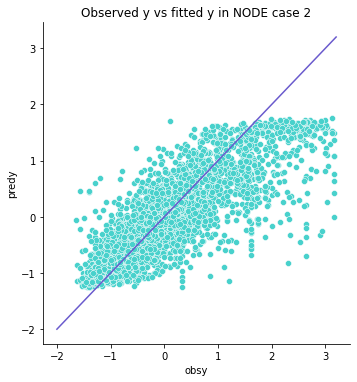

In [75]:
# Observed y vs fitted y
y_df = pd.DataFrame({'obsy':test_y, 'predy':y_pred2})
sns.relplot(x='obsy', y='predy', data=y_df, color="mediumturquoise")
plt.plot([-2, 3.2], [-2, 3.2], color="slateblue")
plt.title("Observed y vs fitted y in NODE case 2");

In [72]:
print(np.max(y_pred2))
print(np.min(y_pred2))

1.7617368
-1.2490935


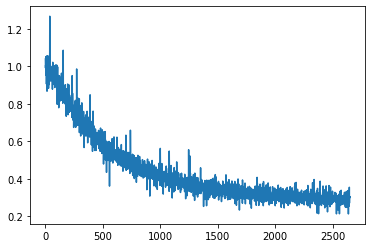

In [74]:
plt.plot(torch.stack(loss_history2).detach().numpy());

#### case 3: hidden layer의 dimension을 더 크게

In [78]:
experiment_name = 'California 0724-7'  # experiment 이름 지정
print("experiment:", experiment_name)

in_features = train_x.shape[1]

model = nn.Sequential(
    lib.DenseBlock(in_features, 128, num_layers=3, tree_dim=3, depth=6, flatten_output=False,
                   choice_function=lib.entmax15, bin_function=lib.entmoid15),
    lib.Lambda(lambda x: x[..., 0].mean(dim=-1)),  # average first channels of every tree
    
).to(device)

# with torch.no_grad():
#     res = model(torch.as_tensor(train_x[:5000], device=device, dtype=torch.float32))
    # trigger data-aware init
    
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
    
optimizer_params = { 'nus':(0.7, 1.0), 'betas':(0.95, 0.998) }
trainer = lib.Trainer(
    model=model, loss_function=F.mse_loss,
    experiment_name=experiment_name,
    warm_start=False,
    Optimizer=QHAdam,
    optimizer_params=optimizer_params,
    verbose=True,
    n_last_checkpoints=5
)

loss_history3, mse_history3 = [], []
best_mse = float('inf')
best_step_mse = 0
early_stopping_rounds = 100
report_frequency = 50

experiment: California 0724-7


In [79]:
for batch in tqdm(lib.iterate_minibatches(train_x, train_y, batch_size=1024, 
                                                shuffle=True, epochs=300)):
    
    metrics = trainer.train_on_batch(*batch, device=device)
    
    loss_history3.append(metrics['loss'])

    if trainer.step % report_frequency == 0:
        trainer.save_checkpoint()
        trainer.average_checkpoints(out_tag='avg')
        trainer.load_checkpoint(tag='avg')
        mse = trainer.evaluate_mse(
            valid_x, valid_y, device=device, batch_size=1024)

        if mse < best_mse:
            best_mse = mse
            best_step_mse = trainer.step
            trainer.save_checkpoint(tag='best_mse')
        mse_history3.append(mse)
        
        trainer.load_checkpoint()  # last
        trainer.remove_old_temp_checkpoints()
        
        print("iteration:{} loss:{} mse:{}".format(trainer.step, metrics['loss'], mse))
#         clear_output(True)
#         plt.figure(figsize=[18, 6])
#         plt.subplot(1, 2, 1)
#         plt.plot(loss_history)
#         plt.title('Loss')
#         plt.grid()
#         plt.subplot(1, 2, 2)
#         plt.plot(mse_history)
#         plt.title('MSE')
#         plt.grid()
#         plt.show()
#         print("Loss %.5f" % (metrics['loss']))
#         print("Val MSE: %0.5f" % (mse))
    if trainer.step > best_step_mse + early_stopping_rounds:
        print('BREAK. There is no improvment for {} steps'.format(early_stopping_rounds))
        print("Best step: ", best_step_mse)
        print("Best Val MSE: %0.5f" % (best_mse))
        break

49it [01:53,  2.54s/it]

Saved logs/California 0724-7\checkpoint_temp_50.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


50it [01:57,  3.02s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_50.pth
iteration:50 loss:0.959396481513977 mse:0.9265832304954529


99it [03:55,  2.67s/it]

Saved logs/California 0724-7\checkpoint_temp_100.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


100it [03:59,  3.16s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_100.pth
iteration:100 loss:0.7585252523422241 mse:0.8721900582313538


149it [06:05,  2.65s/it]

Saved logs/California 0724-7\checkpoint_temp_150.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


150it [06:10,  3.22s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_150.pth
iteration:150 loss:0.7289824485778809 mse:0.8278679847717285


199it [08:16,  2.63s/it]

Saved logs/California 0724-7\checkpoint_temp_200.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


200it [08:21,  3.14s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_200.pth
iteration:200 loss:0.6567076444625854 mse:0.789910078048706


249it [10:33,  2.47s/it]

Saved logs/California 0724-7\checkpoint_temp_250.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


250it [10:38,  3.15s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_250.pth
iteration:250 loss:0.6358450651168823 mse:0.7572057247161865


299it [12:48,  2.16s/it]

Saved logs/California 0724-7\checkpoint_temp_300.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


300it [12:53,  2.98s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_300.pth
iteration:300 loss:0.6067975759506226 mse:0.6958487033843994


349it [15:02,  2.77s/it]

Saved logs/California 0724-7\checkpoint_temp_350.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


350it [15:07,  3.29s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_350.pth
iteration:350 loss:0.5513278245925903 mse:0.647891104221344


399it [17:10,  2.60s/it]

Saved logs/California 0724-7\checkpoint_temp_400.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


400it [17:14,  3.08s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_400.pth
iteration:400 loss:0.5273163318634033 mse:0.6086288690567017


449it [19:17,  2.65s/it]

Saved logs/California 0724-7\checkpoint_temp_450.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


450it [19:21,  3.23s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_450.pth
iteration:450 loss:0.45426735281944275 mse:0.5762139558792114


499it [21:32,  2.87s/it]

Saved logs/California 0724-7\checkpoint_temp_500.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


500it [21:37,  3.40s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_500.pth
iteration:500 loss:0.48206526041030884 mse:0.5512260794639587


549it [23:44,  2.39s/it]

Saved logs/California 0724-7\checkpoint_temp_550.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


550it [23:49,  2.93s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_550.pth
iteration:550 loss:0.44697731733322144 mse:0.5298709273338318


599it [25:54,  2.39s/it]

Saved logs/California 0724-7\checkpoint_temp_600.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


600it [25:58,  2.98s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_600.pth
iteration:600 loss:0.45989489555358887 mse:0.5073018670082092


649it [28:12,  2.89s/it]

Saved logs/California 0724-7\checkpoint_temp_650.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


650it [28:15,  2.75s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_650.pth
iteration:650 loss:0.3756207525730133 mse:0.48970142006874084


699it [30:27,  2.69s/it]

Saved logs/California 0724-7\checkpoint_temp_700.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


700it [30:31,  3.26s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_700.pth
iteration:700 loss:0.44980916380882263 mse:0.4736023247241974


749it [32:42,  2.73s/it]

Saved logs/California 0724-7\checkpoint_temp_750.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


750it [32:47,  3.38s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_750.pth
iteration:750 loss:0.39831995964050293 mse:0.45785775780677795


799it [34:59,  2.87s/it]

Saved logs/California 0724-7\checkpoint_temp_800.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


800it [35:04,  3.56s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_800.pth
iteration:800 loss:0.36541423201560974 mse:0.444968581199646


849it [37:14,  2.77s/it]

Saved logs/California 0724-7\checkpoint_temp_850.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


850it [37:18,  3.36s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_850.pth
iteration:850 loss:0.40834420919418335 mse:0.43353578448295593


899it [39:29,  2.56s/it]

Saved logs/California 0724-7\checkpoint_temp_900.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


900it [39:34,  3.26s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_900.pth
iteration:900 loss:0.42168909311294556 mse:0.4227953851222992


949it [41:40,  2.19s/it]

Saved logs/California 0724-7\checkpoint_temp_950.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


950it [41:44,  2.84s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_950.pth
iteration:950 loss:0.39691784977912903 mse:0.413112610578537


999it [43:54,  2.67s/it]

Saved logs/California 0724-7\checkpoint_temp_1000.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


1000it [43:58,  3.21s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_1000.pth
iteration:1000 loss:0.3989998400211334 mse:0.404158353805542


1049it [45:59,  2.56s/it]

Saved logs/California 0724-7\checkpoint_temp_1050.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


1050it [46:03,  3.04s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_1050.pth
iteration:1050 loss:0.36422988772392273 mse:0.39589133858680725


1099it [48:07,  2.68s/it]

Saved logs/California 0724-7\checkpoint_temp_1100.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


1100it [48:11,  3.14s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_1100.pth
iteration:1100 loss:0.4058181643486023 mse:0.38843923807144165


1149it [50:14,  2.47s/it]

Saved logs/California 0724-7\checkpoint_temp_1150.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


1150it [50:18,  2.97s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_1150.pth
iteration:1150 loss:0.3319892883300781 mse:0.38238704204559326


1199it [52:18,  2.39s/it]

Saved logs/California 0724-7\checkpoint_temp_1200.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


1200it [52:22,  2.93s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_1200.pth
iteration:1200 loss:0.3100748658180237 mse:0.3762679398059845


1249it [54:25,  2.46s/it]

Saved logs/California 0724-7\checkpoint_temp_1250.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


1250it [54:30,  3.14s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_1250.pth
iteration:1250 loss:0.38096120953559875 mse:0.3700331449508667


1299it [56:37,  2.56s/it]

Saved logs/California 0724-7\checkpoint_temp_1300.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


1300it [56:39,  2.44s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_1300.pth
iteration:1300 loss:0.2974691689014435 mse:0.3630642890930176


1349it [58:40,  2.56s/it]

Saved logs/California 0724-7\checkpoint_temp_1350.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


1350it [58:44,  3.08s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_1350.pth
iteration:1350 loss:0.3538419008255005 mse:0.3577885627746582


1399it [1:00:55,  2.79s/it]

Saved logs/California 0724-7\checkpoint_temp_1400.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


1400it [1:01:00,  3.27s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_1400.pth
iteration:1400 loss:0.31205540895462036 mse:0.35148847103118896


1449it [1:03:13,  2.83s/it]

Saved logs/California 0724-7\checkpoint_temp_1450.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


1450it [1:03:18,  3.33s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_1450.pth
iteration:1450 loss:0.321483314037323 mse:0.3452815115451813


1499it [1:05:33,  2.95s/it]

Saved logs/California 0724-7\checkpoint_temp_1500.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


1500it [1:05:38,  3.48s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_1500.pth
iteration:1500 loss:0.340976357460022 mse:0.339878648519516


1549it [1:07:49,  2.52s/it]

Saved logs/California 0724-7\checkpoint_temp_1550.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


1550it [1:07:53,  3.13s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_1550.pth
iteration:1550 loss:0.2860228717327118 mse:0.3371438682079315


1599it [1:10:02,  2.11s/it]

Saved logs/California 0724-7\checkpoint_temp_1600.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


1600it [1:10:06,  2.84s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_1600.pth
iteration:1600 loss:0.30858808755874634 mse:0.33193498849868774


1649it [1:12:14,  2.72s/it]

Saved logs/California 0724-7\checkpoint_temp_1650.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


1650it [1:12:18,  3.23s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_1650.pth
iteration:1650 loss:0.30853790044784546 mse:0.32867634296417236


1699it [1:14:33,  2.83s/it]

Saved logs/California 0724-7\checkpoint_temp_1700.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


1700it [1:14:38,  3.37s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_1700.pth
iteration:1700 loss:0.33170363306999207 mse:0.325710266828537


1749it [1:16:53,  2.93s/it]

Saved logs/California 0724-7\checkpoint_temp_1750.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


1750it [1:16:58,  3.59s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_1750.pth
iteration:1750 loss:0.264401376247406 mse:0.3235974907875061


1799it [1:19:19,  2.97s/it]

Saved logs/California 0724-7\checkpoint_temp_1800.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


1800it [1:19:24,  3.57s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_1800.pth
iteration:1800 loss:0.2838335335254669 mse:0.32076337933540344


1849it [1:21:45,  2.91s/it]

Saved logs/California 0724-7\checkpoint_temp_1850.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


1850it [1:21:49,  3.32s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_1850.pth
iteration:1850 loss:0.3042369484901428 mse:0.31858521699905396


1899it [1:23:51,  2.16s/it]

Saved logs/California 0724-7\checkpoint_temp_1900.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


1900it [1:23:56,  2.79s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_1900.pth
iteration:1900 loss:0.3060416877269745 mse:0.31437718868255615


1949it [1:25:57,  2.60s/it]

Saved logs/California 0724-7\checkpoint_temp_1950.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


1950it [1:26:00,  2.46s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_1950.pth
iteration:1950 loss:0.26858600974082947 mse:0.31221508979797363


1999it [1:28:14,  2.94s/it]

Saved logs/California 0724-7\checkpoint_temp_2000.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


2000it [1:28:19,  3.52s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_2000.pth
iteration:2000 loss:0.2776052951812744 mse:0.31006932258605957


2049it [1:30:23,  2.85s/it]

Saved logs/California 0724-7\checkpoint_temp_2050.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


2050it [1:30:27,  3.30s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_2050.pth
iteration:2050 loss:0.31595396995544434 mse:0.30947139859199524


2099it [1:32:34,  2.63s/it]

Saved logs/California 0724-7\checkpoint_temp_2100.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


2100it [1:32:38,  3.22s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_2100.pth
iteration:2100 loss:0.29710617661476135 mse:0.3073151409626007


2149it [1:34:46,  2.73s/it]

Saved logs/California 0724-7\checkpoint_temp_2150.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


2150it [1:34:51,  3.40s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_2150.pth
iteration:2150 loss:0.2853357493877411 mse:0.3048843443393707


2199it [1:36:52,  2.35s/it]

Saved logs/California 0724-7\checkpoint_temp_2200.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


2200it [1:36:56,  2.89s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_2200.pth
iteration:2200 loss:0.29875415563583374 mse:0.3033030033111572


2249it [1:38:58,  1.98s/it]

Saved logs/California 0724-7\checkpoint_temp_2250.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


2250it [1:39:02,  2.63s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_2250.pth
iteration:2250 loss:0.2860040068626404 mse:0.30143946409225464


2299it [1:41:03,  2.56s/it]

Saved logs/California 0724-7\checkpoint_temp_2300.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


2300it [1:41:07,  3.04s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_2300.pth
iteration:2300 loss:0.2795626223087311 mse:0.29984551668167114


2349it [1:43:07,  2.55s/it]

Saved logs/California 0724-7\checkpoint_temp_2350.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


2350it [1:43:11,  3.05s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_2350.pth
iteration:2350 loss:0.2567630708217621 mse:0.29828956723213196


2399it [1:45:15,  2.68s/it]

Saved logs/California 0724-7\checkpoint_temp_2400.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


2400it [1:45:20,  3.36s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_2400.pth
iteration:2400 loss:0.279690682888031 mse:0.29717716574668884


2449it [1:47:22,  2.50s/it]

Saved logs/California 0724-7\checkpoint_temp_2450.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


2450it [1:47:27,  2.99s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_2450.pth
iteration:2450 loss:0.3230314552783966 mse:0.295137494802475


2499it [1:49:26,  2.37s/it]

Saved logs/California 0724-7\checkpoint_temp_2500.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


2500it [1:49:30,  2.93s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_2500.pth
iteration:2500 loss:0.2816435992717743 mse:0.2938798666000366


2549it [1:51:31,  2.17s/it]

Saved logs/California 0724-7\checkpoint_temp_2550.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


2550it [1:51:35,  2.78s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_2550.pth
iteration:2550 loss:0.27933502197265625 mse:0.2929418087005615


2599it [1:53:37,  2.59s/it]

Saved logs/California 0724-7\checkpoint_temp_2600.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


2600it [1:53:39,  2.46s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_2600.pth
iteration:2600 loss:0.31161263585090637 mse:0.2921021580696106


2649it [1:55:40,  2.60s/it]

Saved logs/California 0724-7\checkpoint_temp_2650.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


2650it [1:55:44,  3.07s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_2650.pth
iteration:2650 loss:0.2559383809566498 mse:0.29148679971694946


2699it [1:57:44,  2.56s/it]

Saved logs/California 0724-7\checkpoint_temp_2700.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


2700it [1:57:48,  3.04s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_2700.pth
iteration:2700 loss:0.29826921224594116 mse:0.28944456577301025


2749it [1:59:53,  2.80s/it]

Saved logs/California 0724-7\checkpoint_temp_2750.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


2750it [1:59:57,  3.29s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_2750.pth
iteration:2750 loss:0.3448115587234497 mse:0.2894221246242523


2799it [2:02:04,  2.74s/it]

Saved logs/California 0724-7\checkpoint_temp_2800.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


2800it [2:02:08,  3.28s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_2800.pth
iteration:2800 loss:0.27131789922714233 mse:0.28838202357292175


2849it [2:04:20,  2.56s/it]

Saved logs/California 0724-7\checkpoint_temp_2850.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


2850it [2:04:24,  3.04s/it]

Loaded logs/California 0724-7\checkpoint_temp_2850.pth
iteration:2850 loss:0.24961939454078674 mse:0.2898651659488678


2899it [2:06:30,  2.02s/it]

Saved logs/California 0724-7\checkpoint_temp_2900.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


2900it [2:06:34,  2.65s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_2900.pth
iteration:2900 loss:0.2716476619243622 mse:0.2868310809135437


2949it [2:08:42,  2.69s/it]

Saved logs/California 0724-7\checkpoint_temp_2950.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


2950it [2:08:46,  3.16s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_2950.pth
iteration:2950 loss:0.2431337535381317 mse:0.2849714756011963


2999it [2:11:01,  2.78s/it]

Saved logs/California 0724-7\checkpoint_temp_3000.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


3000it [2:11:05,  3.28s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_3000.pth
iteration:3000 loss:0.26360228657722473 mse:0.2841264605522156


3049it [2:13:07,  2.54s/it]

Saved logs/California 0724-7\checkpoint_temp_3050.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


3050it [2:13:11,  3.03s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_3050.pth
iteration:3050 loss:0.2523137629032135 mse:0.28327351808547974


3099it [2:15:19,  2.64s/it]

Saved logs/California 0724-7\checkpoint_temp_3100.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


3100it [2:15:23,  3.24s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_3100.pth
iteration:3100 loss:0.2881685793399811 mse:0.2825593650341034


3149it [2:17:34,  2.46s/it]

Saved logs/California 0724-7\checkpoint_temp_3150.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


3150it [2:17:38,  3.05s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_3150.pth
iteration:3150 loss:0.237249955534935 mse:0.2824382781982422


3199it [2:19:49,  2.37s/it]

Saved logs/California 0724-7\checkpoint_temp_3200.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


3200it [2:19:53,  3.02s/it]

Saved logs/California 0724-7\checkpoint_best_mse.pth
Loaded logs/California 0724-7\checkpoint_temp_3200.pth
iteration:3200 loss:0.2401886135339737 mse:0.28165891766548157


3249it [2:22:08,  2.86s/it]

Saved logs/California 0724-7\checkpoint_temp_3250.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


3250it [2:22:10,  2.68s/it]

Loaded logs/California 0724-7\checkpoint_temp_3250.pth
iteration:3250 loss:0.3201062083244324 mse:0.28308525681495667


3299it [2:24:24,  2.80s/it]

Saved logs/California 0724-7\checkpoint_temp_3300.pth
Loaded logs/California 0724-7\checkpoint_avg.pth


3300it [2:24:28,  3.22s/it]

Loaded logs/California 0724-7\checkpoint_temp_3300.pth
iteration:3300 loss:0.2590964436531067 mse:0.2842000126838684


3300it [2:24:31,  2.63s/it]

BREAK. There is no improvment for 100 steps
Best step:  3200
Best Val MSE: 0.28166


In [80]:
y_pred3 = trainer.get_prediction(test_x, test_y, device=device)
print('RMSE: {}'.format(np.sqrt(mean_squared_error(test_y, y_pred3))))
print('Pseudo R^2: {}'.format(getpr2(test_y, y_pred3)))

RMSE: 0.5495582818984985
Pseudo R^2: 0.7069604632274493


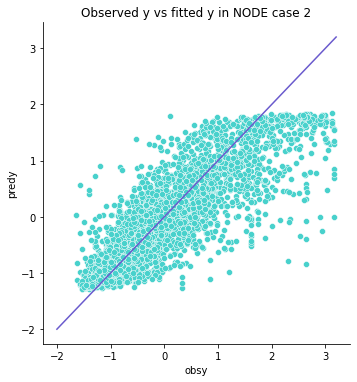

In [81]:
# Observed y vs fitted y
y_df = pd.DataFrame({'obsy':test_y, 'predy':y_pred3})
sns.relplot(x='obsy', y='predy', data=y_df, color="mediumturquoise")
plt.plot([-2, 3.2], [-2, 3.2], color="slateblue")
plt.title("Observed y vs fitted y in NODE case 2");

In [82]:
print(np.max(y_pred3))
print(np.min(y_pred3))

1.8418441
-1.2844582


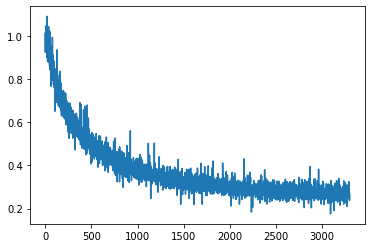

In [83]:
plt.plot(torch.stack(loss_history3).detach().numpy());

#### initialize_response_를 normal 대신 uniform(min(train_y), max(train_y))로

In [6]:
train_y

array([107300., 135300., 117300., ..., 153100., 158600.,  92400.])

In [7]:
np.min(train_y)

14999.0

In [8]:
np.max(train_y)

500000.0

In [13]:
in_features = train_x.shape[1]

model = nn.Sequential(
    lib.DenseBlock(in_features, 128, num_layers=3, tree_dim=3, depth=6, flatten_output=False,
                   choice_function=lib.entmax15, bin_function=lib.entmoid15, 
                   ir = 'uniform', initialize_response_ = nn.init.uniform_, ir_min=np.min(train_y), ir_max=np.max(train_y)),
    lib.Lambda(lambda x: x[..., 0].mean(dim=-1)),  # average first channels of every tree
    
).to(device)

# with torch.no_grad():
#     res = model(torch.as_tensor(train_x[:5000], device=device, dtype=torch.float32))
    # trigger data-aware init
    
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

experiment_name = 'California - exp1'  # experiment 이름 지정
print("experiment:", experiment_name)    

optimizer_params = { 'nus':(0.7, 1.0), 'betas':(0.95, 0.998) }
trainer = lib.Trainer(
    model=model, loss_function=F.mse_loss,
    experiment_name=experiment_name,
    warm_start=False,
    Optimizer=QHAdam,
    optimizer_params=optimizer_params,
    verbose=True,
    n_last_checkpoints=5
)

loss_history3, mse_history3 = [], []
best_mse = float('inf')
best_step_mse = 0
early_stopping_rounds = 100
report_frequency = 50

In [22]:
for batch in tqdm(lib.iterate_minibatches(train_x, train_y, batch_size=1024, 
                                                shuffle=True, epochs=20)):
    
    metrics = trainer.train_on_batch(*batch, device=device)
    
    loss_history3.append(metrics['loss'])

    if trainer.step % report_frequency == 0:
        trainer.save_checkpoint()
        trainer.average_checkpoints(out_tag='avg')
        trainer.load_checkpoint(tag='avg')
        mse = trainer.evaluate_mse(
            valid_x, valid_y, device=device, batch_size=1024)

        if mse < best_mse:
            best_mse = mse
            best_step_mse = trainer.step
            trainer.save_checkpoint(tag='best_mse')
        mse_history3.append(mse)
        
        trainer.load_checkpoint()  # last
        trainer.remove_old_temp_checkpoints()
        
        print("iteration:{} loss:{} mse:{}".format(trainer.step, metrics['loss'], mse))
#         clear_output(True)
#         plt.figure(figsize=[18, 6])
#         plt.subplot(1, 2, 1)
#         plt.plot(loss_history)
#         plt.title('Loss')
#         plt.grid()
#         plt.subplot(1, 2, 2)
#         plt.plot(mse_history)
#         plt.title('MSE')
#         plt.grid()
#         plt.show()
#         print("Loss %.5f" % (metrics['loss']))
#         print("Val MSE: %0.5f" % (mse))
    if trainer.step > best_step_mse + early_stopping_rounds:
        print('BREAK. There is no improvment for {} steps'.format(early_stopping_rounds))
        print("Best step: ", best_step_mse)
        print("Best Val MSE: %0.5f" % (best_mse))
        break

34it [01:17,  2.34s/it]

Saved logs/California - exp1\checkpoint_temp_100.pth
Loaded logs/California - exp1\checkpoint_avg.pth


35it [01:21,  2.79s/it]

Saved logs/California - exp1\checkpoint_best_mse.pth
Loaded logs/California - exp1\checkpoint_temp_100.pth
iteration:100 loss:9016239104.0 mse:9342539512.438839


84it [03:13,  2.34s/it]

Saved logs/California - exp1\checkpoint_temp_150.pth
Loaded logs/California - exp1\checkpoint_avg.pth


85it [03:17,  2.93s/it]

Saved logs/California - exp1\checkpoint_best_mse.pth
Loaded logs/California - exp1\checkpoint_temp_150.pth
iteration:150 loss:8742828032.0 mse:9153186364.540676


134it [05:11,  2.39s/it]

Saved logs/California - exp1\checkpoint_temp_200.pth
Loaded logs/California - exp1\checkpoint_avg.pth


135it [05:16,  2.95s/it]

Saved logs/California - exp1\checkpoint_best_mse.pth
Loaded logs/California - exp1\checkpoint_temp_200.pth
iteration:200 loss:8033401856.0 mse:8940135418.618301


184it [07:10,  2.28s/it]

Saved logs/California - exp1\checkpoint_temp_250.pth
Loaded logs/California - exp1\checkpoint_avg.pth


185it [07:14,  2.89s/it]

Saved logs/California - exp1\checkpoint_best_mse.pth
Loaded logs/California - exp1\checkpoint_temp_250.pth
iteration:250 loss:7884489728.0 mse:8749479628.227919


234it [09:13,  2.00s/it]

Saved logs/California - exp1\checkpoint_temp_300.pth
Loaded logs/California - exp1\checkpoint_avg.pth


235it [09:18,  2.64s/it]

Saved logs/California - exp1\checkpoint_best_mse.pth
Loaded logs/California - exp1\checkpoint_temp_300.pth
iteration:300 loss:8525501440.0 mse:8365298452.840899


260it [10:19,  2.38s/it]


In [23]:
y_pred3 = trainer.get_prediction(test_x, test_y, device=device)
print('RMSE: {}'.format(np.sqrt(mean_squared_error(test_y, y_pred3))))
print('Pseudo R^2: {}'.format(getpr2(test_y, y_pred3)))

RMSE: 90953.34008222909
Pseudo R^2: 0.15286190669737176


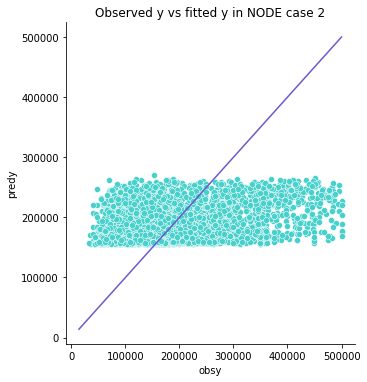

In [24]:
# Observed y vs fitted y
y_df = pd.DataFrame({'obsy':test_y, 'predy':y_pred3})
sns.relplot(x='obsy', y='predy', data=y_df, color="mediumturquoise")
plt.plot([14000, 500010], [14000, 500010], color="slateblue")
plt.title("Observed y vs fitted y in NODE case 2");

In [25]:
print(np.min(y_pred3))
print(np.max(y_pred3))

155292.8
269715.72


In [21]:
print(np.min(test_y))
print(np.max(test_y))

32500.0
500000.0
